Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early.
 It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has 
 the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# importing necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Rescaling,InputLayer
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [2]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Defining the path for train and test images from google drive
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
#checking no. of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing-
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset-
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.



In [6]:
## Writing train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,
subset="training",validation_split=0.2,image_size=(img_height,img_width),batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Writing validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,
         batch_size=batch_size,image_size=(img_height,img_width),subset="validation",
         validation_split=0.2)
                                                             


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

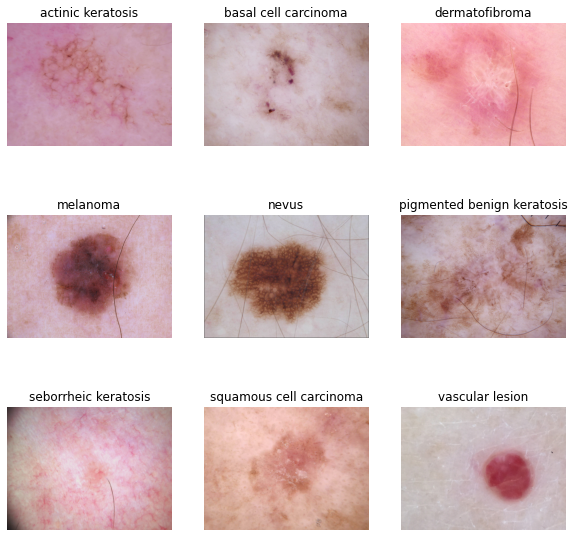

In [9]:
plt.figure(figsize=(10,10))
for idx,images in enumerate(class_names):
    temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
    plt.subplot(3,3,idx+1)
    plt.imshow(temp)
    plt.title(images)
    plt.axis("off")

In [10]:
# checking shape
for image_batch,labels_batch in train_ds:

  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model-

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
preprocessing_layers=[tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3))]

In [13]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'


In [14]:
lr=1e-5
init="normal"
activ="relu"

model=Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(180,180,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("softmax"))

Compile the model

Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

In [17]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 71s 184ms/step - loss: nan - accuracy: 0.0935 - val_loss: nan - val_accuracy: 0.0898
Epoch 2/20
169/169 [==============================] - 23s 134ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 3/20
169/169 [==============================] - 23s 134ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 4/20
169/169 [==============================] - 23s 134ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 5/20
169/169 [==============================] - 23s 133ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 6/20
169/169 [==============================] - 23s 133ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 7/20
169/169 [==============================] - 22s 133ms/step - loss: nan - accuracy: 0.0914 - val_loss: nan - val_accuracy: 0.0898
Epoch 8/20
169/169 [=======

Visualizing training results


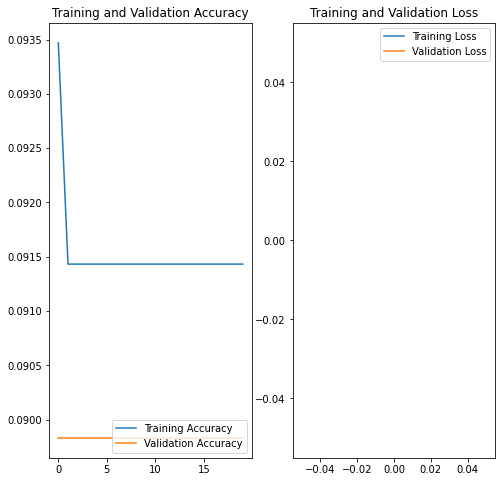

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[link text](https://)Training accuracy=0.091
validation accuracy=0.089
It shows the model is underfitting

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to zero over the dataset
        samplewise_center=False,  # set each sample mean to zero
        featurewise_std_normalization=False,  # divide inputs by std dev of the dataset
        samplewise_std_normalization=False,  # divide each input by its std dev
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift the images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift the images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip the images
        vertical_flip=False)  # randomly flip the images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 2390 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


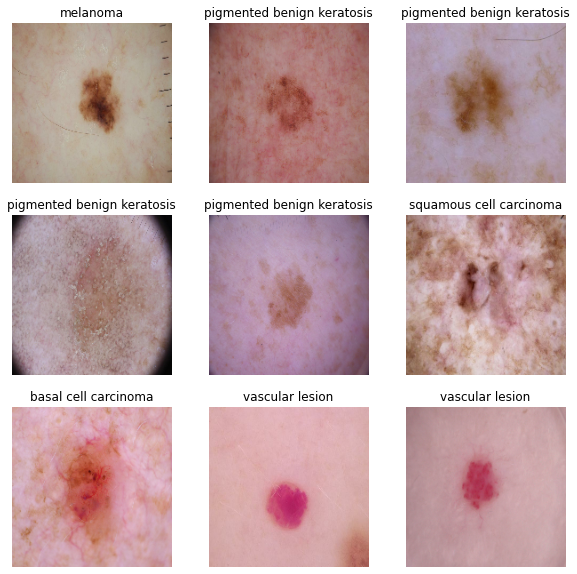

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



Todo:
Create the model, compile and train the model

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

Compiling the model


In [22]:
## Your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

Training the model


In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])


Epoch 1/20
38/38 [==============================] - 105s 3s/step - loss: 72.1182 - accuracy: 0.3310 - val_loss: 2.1334 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 81s 2s/step - loss: 1.1755 - accuracy: 0.3707 - val_loss: 2.0933 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 82s 2s/step - loss: 1.1266 - accuracy: 0.3883 - val_loss: 2.0561 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 81s 2s/step - loss: 1.0599 - accuracy: 0.4293 - val_loss: 1.2318 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 83s 2s/step - loss: 0.9345 - accuracy: 0.5339 - val_loss: 1.1587 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - ETA: 0s - loss: 0.8816 - accuracy: 0.5561
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 [==============================] - 82s 2s/step - loss: 0.

Visualizing the results


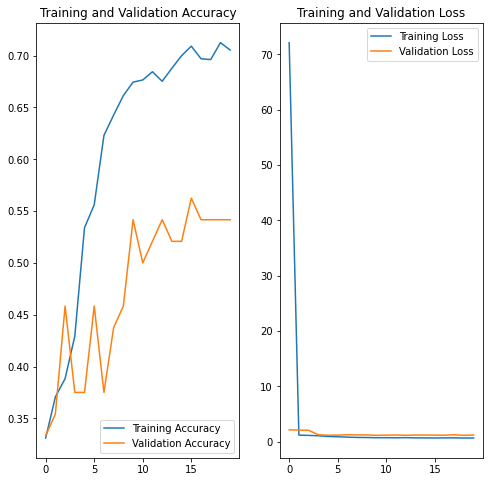

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 model is overfiting
 
Finding the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
for i in class_names:
  print(i,":",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis : 114
basal cell carcinoma : 376
dermatofibroma : 95
melanoma : 438
nevus : 357
pigmented benign keratosis : 462
seborrheic keratosis : 77
squamous cell carcinoma : 181
vascular lesion : 139


<Figure size 720x720 with 0 Axes>

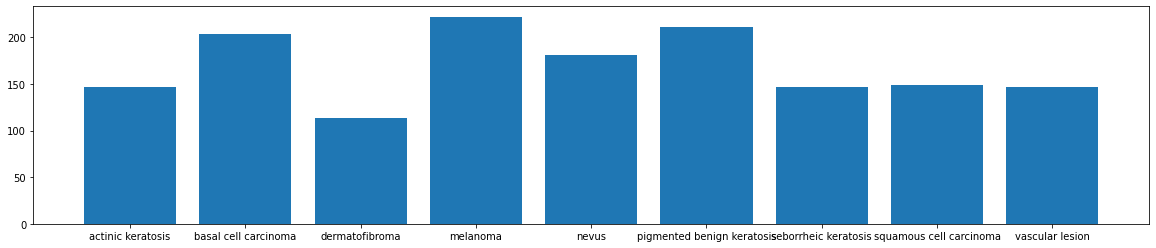

In [27]:

data=dict()
for i in class_names:
  data[i]=[]

plt.figure(figsize=(10,10))
for images,labels in train_ds:
     for i in range(9):
      data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i]=len(data[i])

f=plt.figure()
f.set_figwidth(20)
f.set_figwidth(20)

plt.bar(range(len(data)),list(data.values()),align="center")
plt.xticks(range(len(data)),list(data.keys()))
plt.show()

- seborrheic keratosis class has the least number of samples.
- basal cell carcinoma:376,melanoma : 438,nevus : 357,pigmented benign keratosis:462 classes dominate the data in terms proportionate number of samples


Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples

In [28]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [29]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"


import Augmentor
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EFA92E950>: 100%|██████████| 500/500 [00:27<00:00, 18.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EFA91EAD0>: 100%|██████████| 500/500 [00:29<00:00, 16.94 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EFB817210>: 100%|██████████| 500/500 [00:28<00:00, 17.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F1F74BF6E50>: 100%|██████████| 500/500 [02:01<00:00,  4.11 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EFB870D50>: 100%|██████████| 500/500 [01:47<00:00,  4.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EFB83C3D0>: 100%|██████████| 500/500 [00:26<00:00, 19.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1EFB654CD0>: 100%|██████████| 500/500 [00:53<00:00,  9.36 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EFB8EE550>: 100%|██████████| 500/500 [00:24<00:00, 20.60 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EFB8262D0>: 100%|██████████| 500/500 [00:23<00:00, 20.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.



In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


Lets see the distribution of augmented data after adding new images to the original training data.


In [31]:
from glob import glob
path_list=[x for x in glob(os.path.join(data_dir_train,"*","output","*.jpg"))]
path_list


['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000167.jpg_2a45731d-8cb9-453b-9eea-4e48ee330c89.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010812.jpg_3a893b40-c699-47f1-864f-730dac4e708d.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010209.jpg_f8589d34-f608-4abf-b4e1-68f6bf4cbc90.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010990.jpg_e0b7aefd-eea6-4329-9859-8224e0cdf419.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000555.jpg_0a258a95-2ee7-436a-a836-475ec6a369f6.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin 

In [32]:
lesion_list_new=[os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,"*","output","*.jpg"))] 
lesion_list_new 

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [33]:
dataframe_dict_new=dict(zip(path_list, lesion_list_new))


In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [35]:
new_df["Label"].value_counts()

melanoma                      1000
nevus                         1000
basal cell carcinoma          1000
vascular lesion               1000
actinic keratosis             1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
dermatofibroma                1000
pigmented benign keratosis    1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor


In [36]:
batch_size = 32
img_height = 180
img_width = 180


Todo: Create a training dataset


In [37]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


Todo: Create a validation dataset


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


Todo: Create your model (make sure to include normalization)


In [44]:
## your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 90, 90, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)       

Todo: Compile your model (Choose optimizer and loss function appropriately)


In [45]:
## your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])


Todo: Train your model



In [46]:
epochs = 30

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
281/281 [==============================] - 77s 266ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 2/30
281/281 [==============================] - 76s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 3/30
281/281 [==============================] - 76s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 4/30
281/281 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1208
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
281/281 [==============================] - 76s 266ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 0.0010
Epoch 5/30
281/281 [==============================] - 76s 265ms/step - loss: 0.0000e+00 - accuracy: 0.1208 - val_loss: 0.0000e+00 - val_accuracy: 0.1291 - lr: 5.0000e-04
E

Todo: Visualize the model results

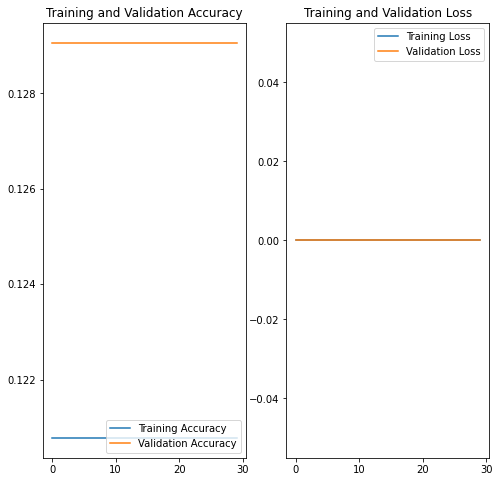

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


The first model was underfitting.we performed augmentation to reduce underfitting.The second model was overfitting.We added dropouts and added more images to rebalance the data.Using rebalancing of data in the third model helped overcome overfitting but the accuracy is very low